In [6]:
from collections import defaultdict
import random
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("tab20")
colors = sns.color_palette("bright")

import time 
import multiprocessing

from algos import *

In [10]:

manager = multiprocessing.Manager()
error_list = manager.list()

def run_trial(
        i_trial, reward_fn, estimator, num_actions, num_samples, args):
    
    random.seed(10000 + i_trial)
    np.random.seed(10000 + i_trial)
    
    # set action_mus and action_sigmas
    if not args["action_mus"]:
        action_mus = 0.02 * (0.05 - 0.02)*np.random.rand(num_actions)
    else:
        action_mus = args["action_mus"]
        
    action_sigmas = args["action_sigmas"]
        
    # print(action_mus)
    # print(action_sigmas)
    # generate rewards
    action_rewards = reward_fn(
        action_mus, action_sigmas, num_actions, num_samples)
    
    # action_mus_hat = np.mean(action_rewards, axis=0)
    # action_sigmas_hat = np.std(action_rewards, axis=0, ddof=1)
    # print(action_mus_hat)
    # print(action_sigmas_hat)
    
    # apply estimator
    mu_est = estimator(action_rewards, num_actions, num_samples, args)    
    # print(mu_est)

    mu_max = np.max(action_mus)
    # print(mu_max)
    error_list.append(mu_est - mu_max)    

# params
num_actions = 6
num_samples = 100
num_trials = 2000

args = dict()
args["weightedms_num_data"] = 1000
args["haver_const"] = 2
args["haver_delta"] = 0.05
    
pool = multiprocessing.Pool()

num_samples_ary = [10, 20, 40, 100, 1000, 2000, 4000, 6000, 8000, 10000]
# num_samples_ary = [10, 25, 50, 100, 250, 500]


action_var = 100
action_mu2_ary = np.arange(0, 5.25, 0.25)
action_mus_ary = [[0, 0, 0, -mu, -mu, -mu] for mu in action_mu2_ary] 

est_bias_dict = defaultdict(lambda: np.zeros((len(num_samples_ary), len(action_mu2_ary))))
est_var_dict = defaultdict(lambda: np.zeros((len(num_samples_ary), len(action_mu2_ary))))
est_mse_dict = defaultdict(lambda: np.zeros((len(num_samples_ary), len(action_mu2_ary))))

haver_const_ary = [1.0, 2.5, 5.0, 7.5, 10.0]                                             
haver_name_ary = [f"haver_{x}" for x in haver_const_ary]
est_name_ary = ["weightedms", "double", "max"]
est_name_ary += haver_name_ary
for est_name in est_name_ary:
    start_time = time.time()
    print(f"\n-> est_name = {est_name}")
    if "haver" in est_name:
        estimator = create_estimator("haver")
        args["haver_const"] = float(est_name.split("_")[-1])
    else:
        estimator = create_estimator(est_name)
    reward_fn = create_reward_fn("normal")
        
    for i_N, num_samples in enumerate(num_samples_ary):
        for i_mu, action_mus in enumerate(action_mus_ary):
            # print(f"\n-> num_samples = {num_samples}, action_mus = {action_mus}")
            args["action_mus"] = action_mus
            args["action_sigmas"] = [np.sqrt(action_var) for i in range(num_actions)]
            num_actions = len(action_mus)

            trial_args = [
                (i, reward_fn, estimator, num_actions, num_samples, args) for i in range(num_trials)]
            pool.starmap(run_trial, trial_args)

            error_ary = np.hstack(error_list)
            est_bias = np.mean(error_ary)
            est_var = np.var(error_ary, ddof=1)
            est_mse = est_bias**2 + est_var

            est_bias_dict[est_name][i_N, i_mu] = est_bias
            est_var_dict[est_name][i_N, i_mu] = est_var
            est_mse_dict[est_name][i_N, i_mu] = est_mse

            error_list[:] = []
        
    end_time = time.time()
    print(f"it takes {end_time-start_time:0.4f}")
    


-> est_name = weightedms


Process ForkPoolWorker-17:
Process ForkPoolWorker-21:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tnn/miniconda3/envs/tnn1/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tnn/m

KeyboardInterrupt: 

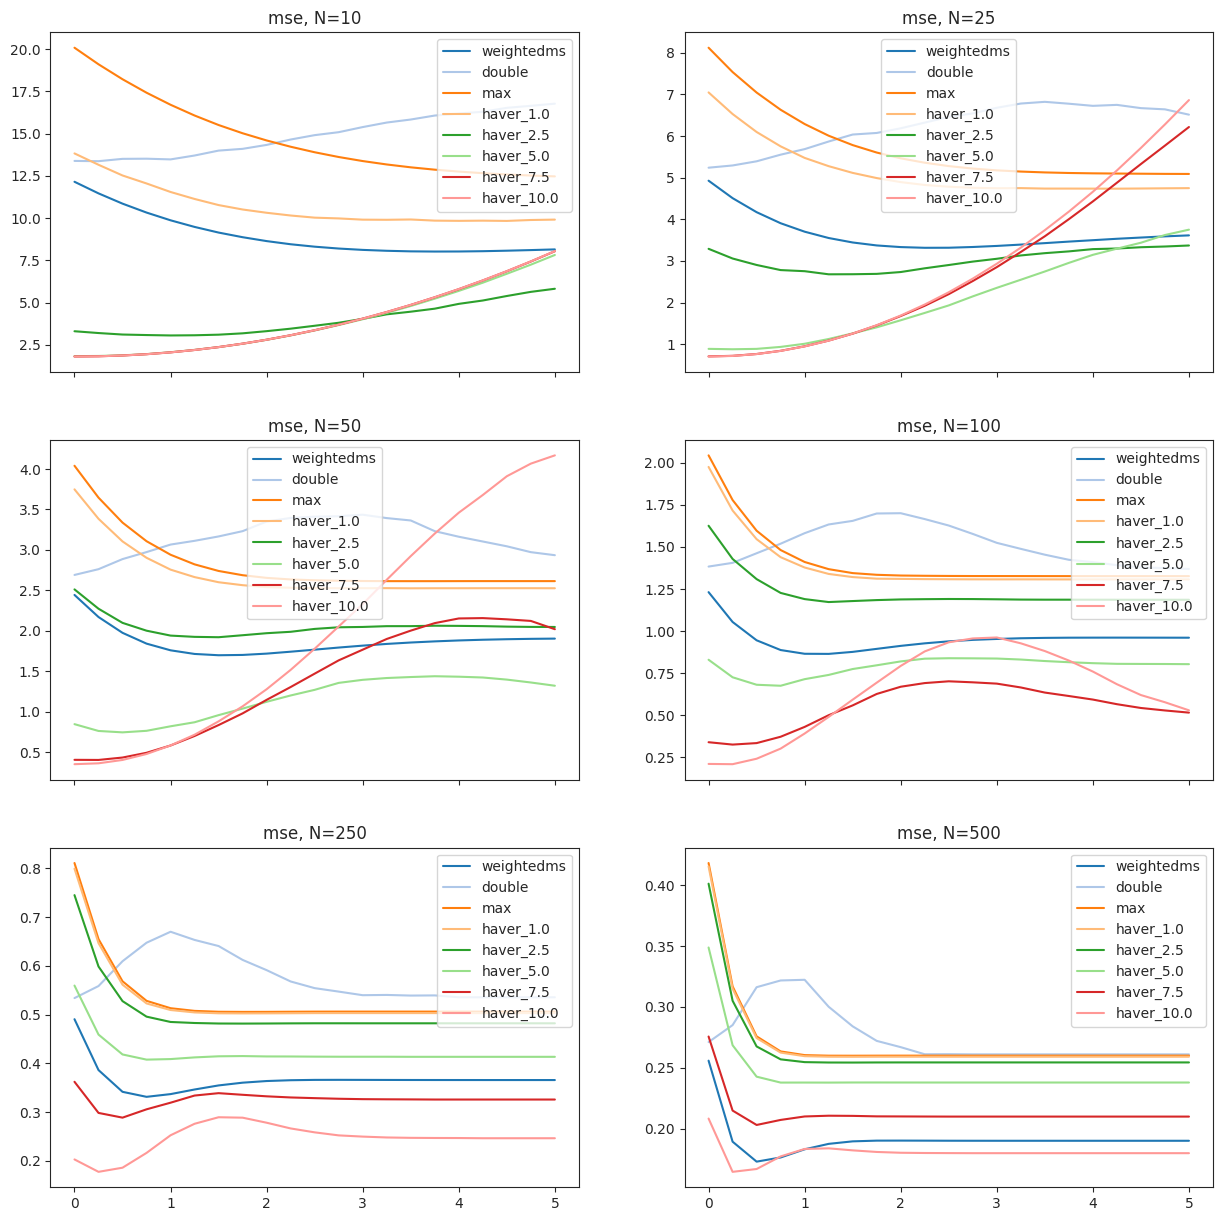

In [7]:
fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15,15))
# axes = [axes]
axes = axes.ravel()

x_ary = action_mu2_ary

for i_N, num_samples in enumerate(num_samples_ary):
    for est_name in est_name_ary:
        axes[i_N].plot(x_ary, est_mse_dict[est_name][i_N,:], label=est_name)
        axes[i_N].set_title(f"mse, N={num_samples}")
        axes[i_N].legend()
        
plt.show()

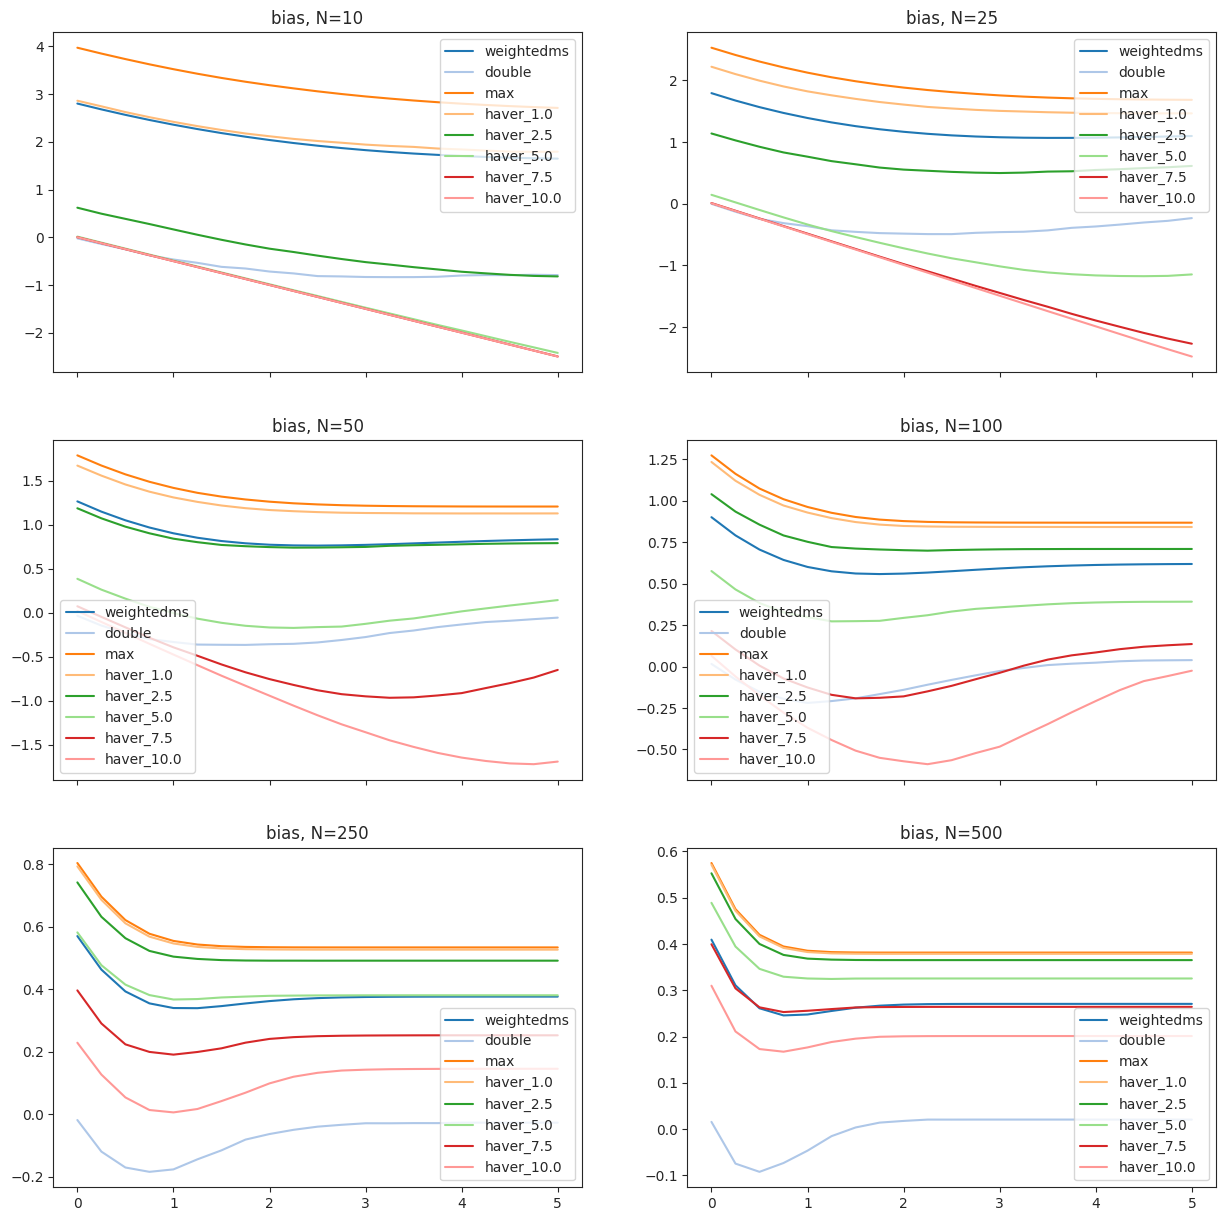

In [8]:
fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15,15))
# axes = [axes]
axes = axes.ravel()

x_ary = action_mu2_ary

for i_N, num_samples in enumerate(num_samples_ary):
    for est_name in est_name_ary:
        axes[i_N].plot(x_ary, est_bias_dict[est_name][i_N,:], label=est_name)
        axes[i_N].set_title(f"bias, N={num_samples}")
        axes[i_N].legend()
        
plt.show()

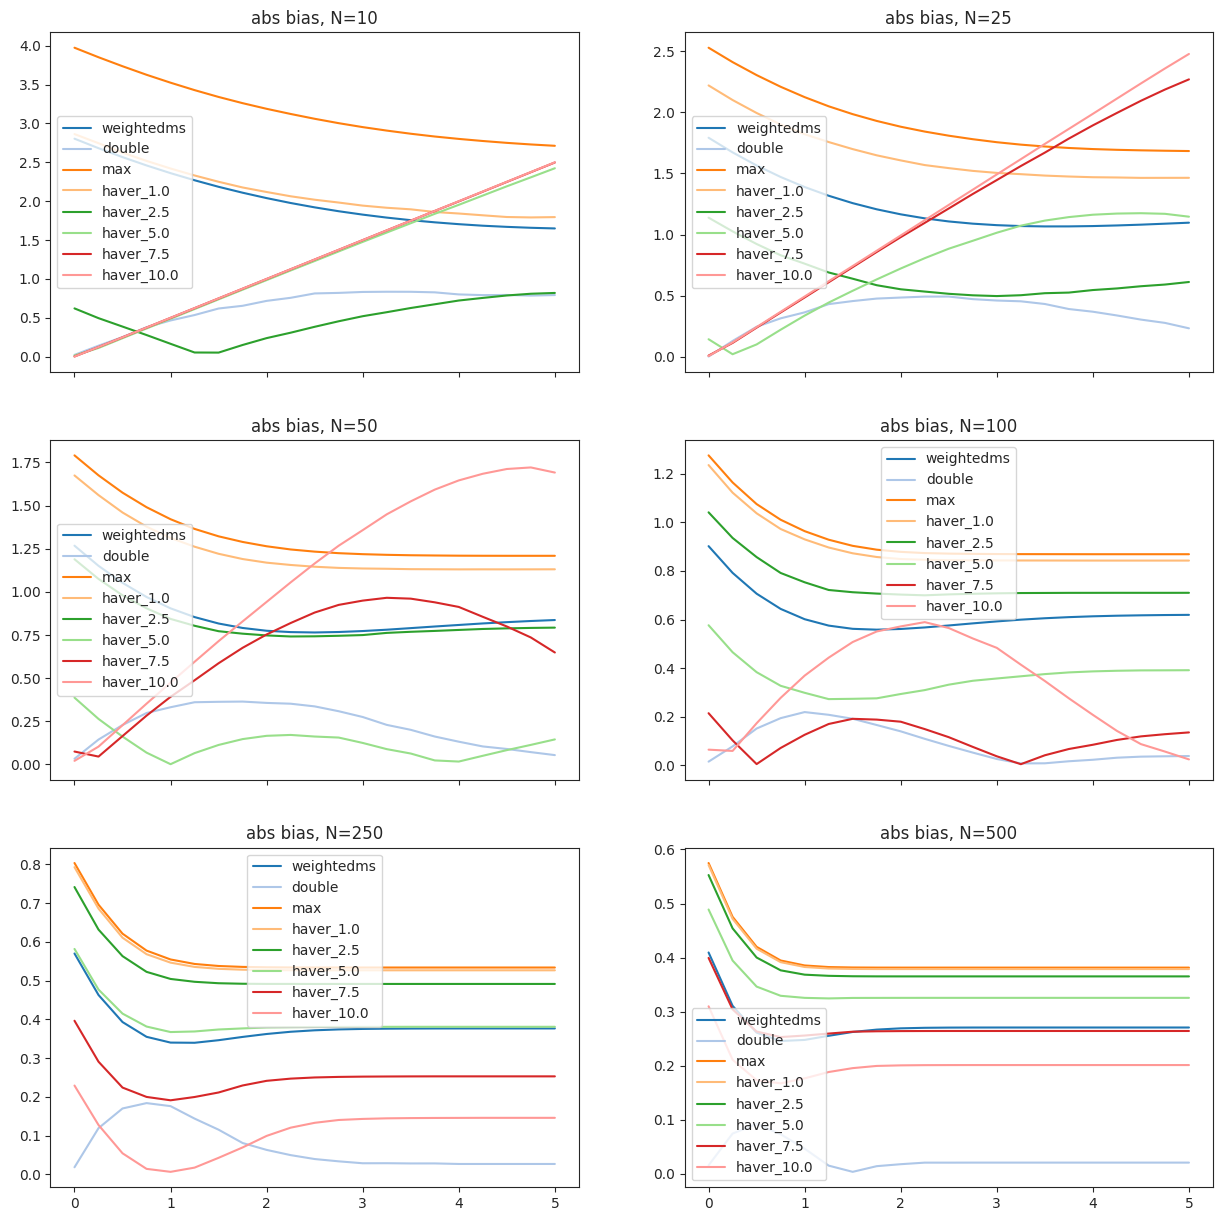

In [9]:
fig, axes = fig, axes = plt.subplots(
        nrows=3, ncols=2, sharex=True, sharey=False, figsize=(15,15))
# axes = [axes]
axes = axes.ravel()

x_ary = action_mu2_ary

for i_N, num_samples in enumerate(num_samples_ary):
    for est_name in est_name_ary:
        axes[i_N].plot(x_ary, np.abs(est_bias_dict[est_name][i_N,:]), label=est_name)
        axes[i_N].set_title(f"abs bias, N={num_samples}")
        axes[i_N].legend()
        
plt.show()